In [2]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import warnings
import sys
import subprocess
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

model_name = "roberta-large-mnli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
ds = load_dataset("wangrongsheng/ag_news")


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [4]:
# def start_gemma2_session():
#     """
#     Start Gemma2 through Ollama and return the process instance.

#     Returns:
#         subprocess.Popen: Persistent Gemma2 process.
#     """
#     gemma2_process = subprocess.Popen(
#         ["ollama", "run", "gemma2"],
#         stdin=subprocess.PIPE,
#         stdout=subprocess.PIPE,
#         stderr=subprocess.PIPE,
#         text=True
#     )
#     return gemma2_process


In [5]:
# def interact_with_gemma2(gemma2_process, prompt):
#     """
#     Send a prompt to Gemma2 and retrieve its response.

#     Args:
#         gemma2_process (subprocess.Popen): The running Gemma2 process.
#         prompt (str): The prompt to send.

#     Returns:
#         str: The response from Gemma2.
#     """
#     # Write the prompt to Gemma2
#     gemma2_process.stdin.write(prompt + "\n")
#     gemma2_process.stdin.flush()

#     # Read the response
#     response = gemma2_process.stdout.readline().strip()
#     return response



In [6]:
classifier = pipeline('zero-shot-classification', model=model_name, device=1)                              
sequence_to_classify = "This is a test"
candidate_labels = ['travel', 'cooking', 'dancing', 'technician', 'teacher']
classifier(sequence_to_classify, candidate_labels)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'sequence': 'This is a test',
 'labels': ['technician', 'travel', 'teacher', 'dancing', 'cooking'],
 'scores': [0.4375876188278198,
  0.17017927765846252,
  0.16035453975200653,
  0.13061025738716125,
  0.10126830637454987]}

In [7]:
def perform_error_analysis(dataset, classifier, label_map, num_samples=100):
    """
    Perform comprehensive error analysis on the zero-shot classifier.
    Returns the analysis results as a string and the results DataFrame.
    
    Args:
        dataset: The AG News dataset
        classifier: The zero-shot classification pipeline
        label_map: Dictionary mapping label indices to descriptions
        num_samples: Number of samples to analyze (use smaller number for testing)
    """
    # AG News labels mapping

    
    # label_map = {
    #     0: "Classify as World News if related to global events or international affairs",
    #     1: "Label as Sports News if about athletic events, teams, or player stories",
    #     2: "Categorize as Business News if focusing on companies, markets, or financial reports",
    #     3: "Mark as Science and Technology News if involving innovations, discoveries, or emerging tech" 
    # }
    # label_map = {
    #     0: "World",
    #     1: "Sports",
    #     2: "Business",
    #     3: "Sci/Tech"
    # }
    output_string = ""
    
    # Prepare candidate labels for zero-shot classification
    candidate_labels = list(label_map.values())
    output_string += f"Candidate labels: {candidate_labels}\n\n"
    
    # Store results
    results = []
    
    # Process test samples
    for i, item in tqdm(enumerate(dataset['test']), total=num_samples):
        if i >= num_samples:
            break
            
        text = item['text']
        true_label = label_map[item['label']]
        
        # Get model prediction
        prediction = classifier(text, candidate_labels)
        predicted_label = prediction['labels'][0]
        confidence = prediction['scores'][0]
        
        results.append({
            'text': text,
            'true_label': true_label,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'correct': true_label == predicted_label
        })
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    # 1. Overall Accuracy
    accuracy = (df_results['correct'].sum() / len(df_results)) * 100
    output_string += f"Overall Accuracy: {accuracy:.2f}%\n\n"
    
    # 2. Per-class Performance
    output_string += "Per-class Performance:\n"
    class_report = classification_report(df_results['true_label'], df_results['predicted_label'])
    output_string += f"{class_report}\n"
    
    # 5. Error Examples Analysis
    output_string += "Most Confident Mistakes:\n"
    mistakes = df_results[~df_results['correct']].sort_values('confidence', ascending=False)
    mistake_df = mistakes[['text', 'true_label', 'predicted_label', 'confidence']].head()
    output_string += mistake_df.to_string()
    output_string += "\n"
    
    # 3. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(df_results['true_label'], df_results['predicted_label'], labels=candidate_labels)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=candidate_labels, yticklabels=candidate_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df_results, output_string, accuracy

In [8]:
from collections import defaultdict

def analyze_error_patterns(df_results):
    """
    Analyze specific patterns in the errors and return them as a string.
    """
    # Common misclassification patterns
    error_patterns = defaultdict(int)
    for _, row in df_results[~df_results['correct']].iterrows():
        pattern = f"{row['true_label']} → {row['predicted_label']}"
        error_patterns[pattern] += 1

    # Collect the output lines in a list
    output_lines = ["\nCommon Error Patterns:"]
    for pattern, count in sorted(error_patterns.items(), key=lambda x: x[1], reverse=True):
        output_lines.append(f"{pattern}: {count}")

    # Join the lines into a single string and return
    # print("\n".join(output_lines))
    return "\n".join(output_lines)

        
    # # Confidence threshold analysis
    # thresholds = np.arange(0.1, 1.0, 0.1)
    # accuracies = []
    # coverage = []
    
    # for threshold in thresholds:
    #     filtered_preds = df_results[df_results['confidence'] >= threshold]
    #     if len(filtered_preds) > 0:
    #         acc = (filtered_preds['correct'].sum() / len(filtered_preds)) * 100
    #         cov = (len(filtered_preds) / len(df_results)) * 100
    #         accuracies.append(acc)
    #         coverage.append(cov)
    
    # # Ensure arrays are the same length before plotting
    # min_len = min(len(accuracies), len(coverage))
    # thresholds = thresholds[:min_len]
    # accuracies = accuracies[:min_len]
    # coverage = coverage[:min_len]
    
    # if min_len > 0:  # Only plot if we have data
    #     plt.figure(figsize=(10, 6))
    #     plt.plot(thresholds, accuracies, 'b-', label='Accuracy')
    #     plt.plot(thresholds, coverage, 'r-', label='Coverage')
    #     plt.xlabel('Confidence Threshold')
    #     plt.ylabel('Percentage')
    #     plt.title('Accuracy vs Coverage Trade-off')
    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()
    # else:
    #     print("Warning: Not enough data points to create accuracy-coverage plot")


STOP

In [9]:
# # Example usage
# if __name__ == "__main__":
#     # Initialize Gemma2 session
#     gemma2 = start_gemma2_session()

#     # Initial prompt
#     initial_prompt = "You are an expert prompt generator for a zero shot text classification task. I am using roberta-large-mnli to do zero shot classification on the ag news dataset. I will first provide you with the truth labels corresponding to the 4 types of texts in the ag news dataset (in total the dataset has over one hundred thousand different texts then iteratively I will provide you with the current prompts that have been given to the model and the corresponding accuracy of the model per label on the task, I want you to provide better prompts for all the four labels so that the accuracy of the model improves. We will have many iterations of this process and I want you to iteratively give better prompts. Your output should be of the format 0: \"prompt0\", 1: \"prompt1\", 2: \"prompt2\", 3: \"prompt3\" (without the \ because that's only for passing double string to you in python) where the values of the dictionary correspond to the prompts that you generate. Do not generate any text other than these prompts in dictionary format. If after 2-3 iterations the accuracy doesn't increase by much than try different methods. Also if you are able to achieve precision of over 90 for any of the four labels then don't change the prompt for those by much."
#     current_prompt = initial_prompt

#     # Iteratively refine the prompt using Gemma2
#     iterations = 3
#     for i in range(iterations):
#         print(f"Iteration {i + 1}: Current Prompt -> {current_prompt}")
#         refined_prompt = interact_with_gemma2(gemma2, current_prompt)
#         print(f"Refined Prompt -> {refined_prompt}")
#         current_prompt = refined_prompt

#         # Use the refined prompt for classification
#         print("\nUsing the final refined prompt for analysis...")
#         candidate_labels = [f"{refined_prompt} ({label})" for label in ["politics", "sports", "economics", "science and technology"]]

#         # Perform main error analysis with the refined prompt
#         results_df = perform_error_analysis(ds, classifier, num_samples=500, prompt=refined_prompt)
        
#         # Analyze error patterns
#         analyze_error_patterns(results_df)

#     # Terminate Gemma2 session
#     gemma2.terminate()
#{0: 'This text is about global events, international conflicts, or geopolitical dynamics', 1: 'The topic of this article is sports related', 2: 'This piece of writing focuses on corporate news, market analysis, or financial industry trends', 3: 'The subject matter of this text involves science, technology, or innovations'}

  0%|          | 0/3000 [00:00<?, ?it/s]

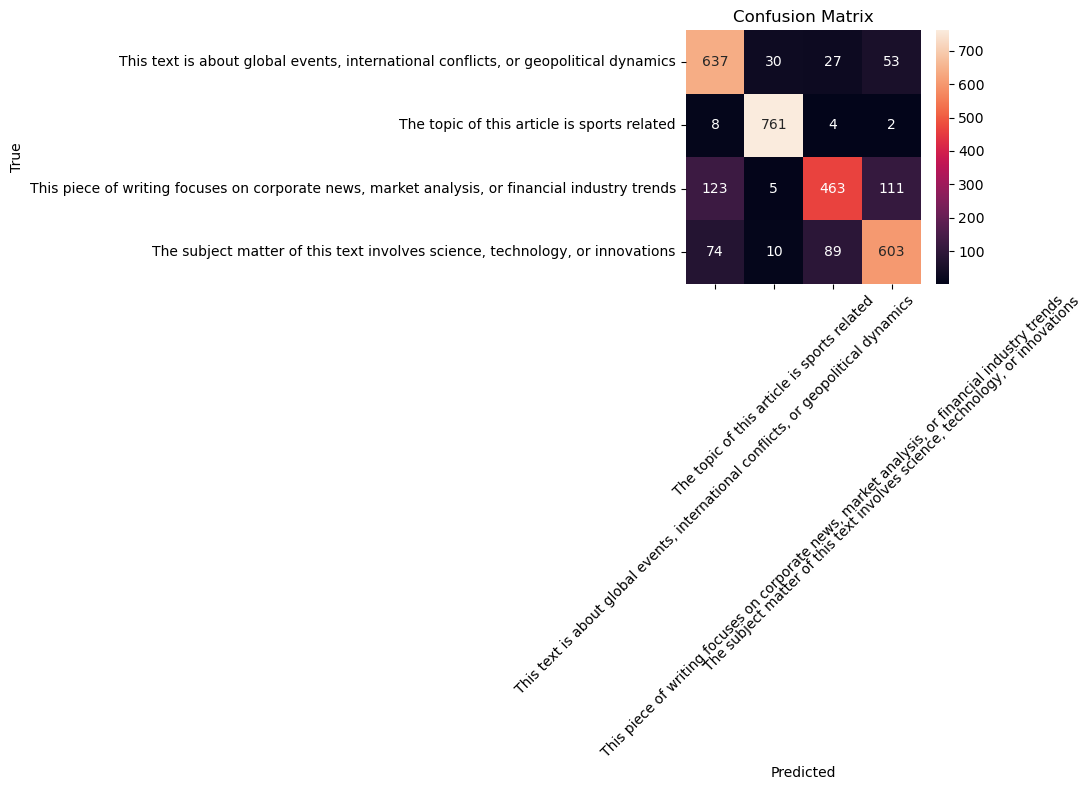

82.13333333333334
Candidate labels: ['This text is about global events, international conflicts, or geopolitical dynamics', 'The topic of this article is sports related', 'This piece of writing focuses on corporate news, market analysis, or financial industry trends', 'The subject matter of this text involves science, technology, or innovations']

Overall Accuracy: 82.13%

Per-class Performance:
                                                                                                precision    recall  f1-score   support

                  The subject matter of this text involves science, technology, or innovations       0.78      0.78      0.78       776
                                                   The topic of this article is sports related       0.94      0.98      0.96       775
This piece of writing focuses on corporate news, market analysis, or financial industry trends       0.79      0.66      0.72       702
           This text is about global events, internation

In [13]:
label_map = {
    0: 'This text is about global events, international conflicts, or geopolitical dynamics', 
    1: 'The topic of this article is sports related', 
    2: 'This piece of writing focuses on corporate news, market analysis, or financial industry trends', 
    3: 'The subject matter of this text involves science, technology, or innovations'
    }

results_df, output1, accuracy=perform_error_analysis(ds,classifier, label_map, 3000)
print(accuracy, output1, sep='\n')


In [ ]:
# from ollama import chat

# models = ['nemotron']

message = '''You are an expert prompt generator for a zero shot text classification task. I am using roberta-large-mnli to do zero shot classification on the ag news dataset.  
I will first provide you with the truth labels corresponding to the 4 types of texts in the ag news dataset (in total the dataset has over one hundred thousand different texts). 
The AG News dataset provides us with the following intial labels: 0: World, 1: Sports, 2: Business, 4: Sci/Tech
Then iteratively, I will provide you with the current prompts that have been given to the model and the corresponding accuracy of the model per label on the task.
I want you to provide better prompts for all the four labels so that the accuracy of the model improves. We will have many iterations of this process and I want you to iteratively give better prompts.
I will also give you the per class accuracy, the most confident mistakes, and common error patterns observed for the given labels. Infer whatever you want to from them and try to make your results better.(Follow the format exactly, dont miss any commas or inverted commas)
Your output should be of the format 0: \"prompt0\", 1: \"prompt1\", 2: \"prompt2\", 3: \"prompt3\" where the values of the dictionary correspond to the prompts that you generate. (The prompts aren't questions, they are assertions)
Do not generate any text other than these prompts in dictionary format. 
Also if you are able to achieve precision of over 0.90 for any of the four labels then don't change the prompt for those at all.
This is my initial input to you, from the next message onwards, I will start giving the above mentioned data as the message, I won't provide any other information in the subsequent messages, so use the information I gave in this message to interpret the data provided.
Also, don't give any non alphanumeric characters in the output such as emojis or emoticons. 
Overall Accuracy: 48.50%

Per-class Performance:
              precision    recall  f1-score   support

    Business       0.36      0.08      0.13       205
    Sci/Tech       0.91      0.21      0.34       253
      Sports       0.75      0.68      0.72       274
       World       0.35      0.85      0.50       268

    accuracy                           0.48      1000
   macro avg       0.60      0.46      0.42      1000
weighted avg       0.61      0.48      0.44      1000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                    text  \
702                                                                                                                                  HP Unveils Cavalcade of Consumer Products (PC World) PC World - First TVs, new printers, long-lasting inks, and projectors are targeted\ at living room and office.   
624  World #39;s smallest digital camera with zoom lens Come September, Japanese electronics giant Casio Computer will launch the world #39;s smallest digital camera with a zoom lens. Casio #39;s palm-sized Exilim camera is much smaller than others as, for the first time, it uses a ceramic lens.   
468                                                                                              Microsoft: Use Script to Block Windows XP SP2 Updates Microsoft has offered up yet another way for businesses to block the automatic update of Windows XP to the big-deal Service Pack 2 (SP2) upgrade.   
821                                                                                                  We owe Athens an apology ATHENS -- The Games of the XXVIII Olympiad -- the great disaster that wasn #39;t -- come to an emotional end this afternoon and, really, the world owes Athens an apology.   
963                                       EU, Japan Win WTO Approval to Impose Duties on US (Update2) The European Union, Japan and Brazil won World Trade Organization backing to impose tariffs on US imports after Congress failed to end illegal corporate subsidies worth \$850 million since 2001.   

    true_label predicted_label  confidence  
702   Sci/Tech           World    0.952798  
624   Sci/Tech           World    0.937181  
468   Sci/Tech        Business    0.881427  
821     Sports           World    0.867683  
963   Business           World    0.826846  


Common Error Patterns:
Business → World: 173
Sci/Tech → World: 160
Sports → World: 87
World → Sports: 36
Sci/Tech → Business: 28
Business → Sports: 14
Sci/Tech → Sports: 12
World → Sci/Tech: 3
Business → Sci/Tech: 2

(print only in the format described and print nothing else, don't forget the double quotations for the prompts)
    Output format: {0: "prompt0", 1: "prompt1", 2: "prompt2", 3: "prompt3"}

'''

# for i in models:
#   print("Model name:", i)
#   stream = chat(
#       model=i,
#       messages=[{'role': 'user', 'content': message}],
#       stream=True,
#   )
  
#   for chunk in stream:
#     print(chunk['message']['content'], end='', flush=True)
#   print()

In [ ]:
from ollama import chat
import ast
import matplotlib.pyplot as plt

MAX_ITERATIONS = 100

# Initialize model and variables
model_name = 'nemotron'

# Initial label map
label_map = {0: 'World', 1: 'Sports', 2: 'Business', 4: 'Sci/Tech'}
best_accuracy = 48.5
accuracy_data = [48.5]
iteration_data = list(range(1, MAX_ITERATIONS + 1))

initial_interaction = True
# Function to interact with the LLM
def interact_with_llm(model_name, prompt):
    
    stream = chat(
        model=model_name,
        messages=[{'role': 'user', 'content': prompt}],
        stream=True,
    )
    response = ""
    for chunk in stream:
        response += chunk['message']['content']
    new_labels=response.strip()
    print(new_labels)
    dictionary = ast.literal_eval(new_labels)
    return dictionary

# Loop for iterative prompt refinement
iteration = 1
response = ""
while iteration <= MAX_ITERATIONS:
    print(f"\nIteration {iteration}: Current label prompts:")
    for k, v in label_map.items():
        print(f"{k}: \"{v}\"") 
    if(initial_interaction):
        label_map = interact_with_llm(model_name, message)
        initial_interaction = False
    
    else:

        

        # Get outputs from func1 and func2
        results_df, output1, accuracy = perform_error_analysis(ds, classifier, label_map, num_samples=3000)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        output2 = analyze_error_patterns(results_df)
        accuracy_data.append(accuracy)

        # print(f"func1 output: {output1}")
        # print(f"func2 output: {output2}")
        
        # Prepare input message for the LLM
        llm_input = f"""
            Here are the current prompts for labels:\n{label_map}
            Here is the analysis for your last set of prompts/labels for the data:
            {output1}
            {output2}
            
            The original labels provided by AG News were: 0: World, 1: Sports, 2: Business, 4: Sci/Tech
            
            Using this and the current prompts, generate improved prompts for the labels.(print only in the format described and print nothing else, also the prompts should not be questions, rather they should be assertions, foreg. try to start your prompt/label with "This text is about.." or something like that) If you are able to achieve precision of over 0.90 for any of the four labels then don't change the prompt for those at all, unless all 4 have precision of greater than 0.90, then you can try to improve the parts a little bit. respond with the exact output format and nothing else.
            Output format: {{0: "prompt0", 1: "prompt1", 2: "prompt2", 3: "prompt3"}}"""
    
        print(llm_input)

        # Send current prompts and function outputs to the LLM
        label_map = interact_with_llm(model_name, llm_input)

        

    iteration += 1


plt.figure(figsize=(8, 6))
plt.plot(iteration_data, accuracy_data, marker= 'o', linestyle = '-', color = 'b', label = 'Data Points')

plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title("Prediction Accuracy obtained using labels returned by a LLM")
plt.legend()
plt.grid(True)

plt.show()







Iteration 1: Current label prompts:
0: "World"
1: "Sports"
2: "Business"
4: "Sci/Tech"
{0: "This text is about global events or international news", 
1: "The topic of this article is sports related", 
2: "This piece of writing focuses on corporate or financial news", 
3: "The subject matter of this text involves science, technology, or innovations"}

Iteration 2: Current label prompts:
0: "This text is about global events or international news"
1: "The topic of this article is sports related"
2: "This piece of writing focuses on corporate or financial news"
3: "The subject matter of this text involves science, technology, or innovations"


  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about global events or international news', 1: 'The topic of this article is sports related', 2: 'This piece of writing focuses on corporate or financial news', 3: 'The subject matter of this text involves science, technology, or innovations'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global events or international news', 'The topic of this article is sports related', 'This piece of writing focuses on corporate or financial news', 'The subject matter of this text involves science, technology, or innovations']

Overall Accuracy: 80.70%

Per-class Performance:
                                                                              precision    recall  f1-score   support

The subject matter of this text involves science, technology, or innovations       0.77      0.72      0.75       776
                                 T

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about geopolitics, global issues, or international relations', 1: 'The topic of this article is sports related', 2: 'This piece of writing primarily discusses company operations, financial markets, or economic trends', 3: 'The subject matter of this text involves science, technology, or innovations'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about geopolitics, global issues, or international relations', 'The topic of this article is sports related', 'This piece of writing primarily discusses company operations, financial markets, or economic trends', 'The subject matter of this text involves science, technology, or innovations']

Overall Accuracy: 72.13%

Per-class Performance:
                                                                                                     precision    recall  f1-score   support

             

  0%|          | 0/3000 [00:00<?, ?it/s]


            Here are the current prompts for labels:
{0: 'This text is about global events, international conflicts, or geopolitical dynamics', 1: 'The topic of this article is sports related', 2: 'This piece of writing focuses on corporate news, market analysis, or financial industry trends', 3: 'The subject matter of this text involves science, technology, or innovations'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global events, international conflicts, or geopolitical dynamics', 'The topic of this article is sports related', 'This piece of writing focuses on corporate news, market analysis, or financial industry trends', 'The subject matter of this text involves science, technology, or innovations']

Overall Accuracy: 82.13%

Per-class Performance:
                                                                                                precision    recall  f1-score   support

        

  0%|          | 0/3000 [00:00<?, ?it/s]

In [18]:
import re

# Input string (your data)
data = """

Iteration 1: Current label prompts:
0: "World"
1: "Sports"
2: "Business"
4: "Sci/Tech"
{0: "This text is about global events or news from around the World", 
1: "The main topic of this article is related to Sports and physical activities", 
2: "This piece of writing focuses on Business, finance, or corporate matters", 
3: "The subject matter revolves around Science, Technology, or innovative discoveries"}

Iteration 2: Current label prompts:
0: "This text is about global events or news from around the World"
1: "The main topic of this article is related to Sports and physical activities"
2: "This piece of writing focuses on Business, finance, or corporate matters"
3: "The subject matter revolves around Science, Technology, or innovative discoveries"
100%
 3000/3000 [02:36<00:00, 23.18it/s]

            Here are the current prompts for labels:
{0: 'This text is about global events or news from around the World', 1: 'The main topic of this article is related to Sports and physical activities', 2: 'This piece of writing focuses on Business, finance, or corporate matters', 3: 'The subject matter revolves around Science, Technology, or innovative discoveries'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['This text is about global events or news from around the World', 'The main topic of this article is related to Sports and physical activities', 'This piece of writing focuses on Business, finance, or corporate matters', 'The subject matter revolves around Science, Technology, or innovative discoveries']

Overall Accuracy: 65.00%

Per-class Performance:
                                                                                   precision    recall  f1-score   support

      The main topic of this article is related to Sports and physical activities       0.95      0.80      0.87       775
The subject matter revolves around Science, Technology, or innovative discoveries       0.79      0.31      0.45       776
         This piece of writing focuses on Business, finance, or corporate matters       0.64      0.58      0.61       702
                   This text is about global events or news from around the World       0.48      0.91      0.63       747

                                                                         accuracy                           0.65      3000
                                                                        macro avg       0.72      0.65      0.64      3000
                                                                     weighted avg       0.72      0.65      0.64      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                                      text                                                                         true_label                                                           predicted_label  confidence
1190  Hurricanes Bring Environmental Renewal (AP) AP - Along with their destructive force, hurricanes can have beneficial effects as part of the rhythm of nature. Storms that erode beaches, uproot trees and flatten wildlife habitats may also refresh waterways, revive dry areas and bulk up barrier islands with redistributed sand.  The subject matter revolves around Science, Technology, or innovative discoveries            This text is about global events or news from around the World    0.930590
2006                                                                                                                     Apple offers 2004 financial details Apple's latest Form 10-K filing with the Securities and Exchange Commission offers a look at how the company did this past year, how it thinks it's doing and what's to come.  The subject matter revolves around Science, Technology, or innovative discoveries  This piece of writing focuses on Business, finance, or corporate matters    0.926745
1864                                                                                           Group Seeks Ways to Prosecute Cybercrime (AP) AP - Governments and private sector officials from around the world sought ways Thursday to jointly combat cybercrime, whose growth mirrors the phenomenal rise of the Internet's popularity.  The subject matter revolves around Science, Technology, or innovative discoveries            This text is about global events or news from around the World    0.889428
...
0: "Text primarily covers international news, geopolitical developments, or worldwide events"
1: "Article content is centered around athletic competitions, sports teams, or physical activity"
2: "Focus is on corporate operations, financial markets, economic trends, or industry analysis"
3: "Content emphasizes emerging technologies, scientific breakthroughs, innovations, or technical discoveries"
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:37<00:00, 23.23it/s]

            Here are the current prompts for labels:
{0: 'Text primarily covers international news, geopolitical developments, or worldwide events', 1: 'Article content is centered around athletic competitions, sports teams, or physical activity', 2: 'Focus is on corporate operations, financial markets, economic trends, or industry analysis', 3: 'Content emphasizes emerging technologies, scientific breakthroughs, innovations, or technical discoveries'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['Text primarily covers international news, geopolitical developments, or worldwide events', 'Article content is centered around athletic competitions, sports teams, or physical activity', 'Focus is on corporate operations, financial markets, economic trends, or industry analysis', 'Content emphasizes emerging technologies, scientific breakthroughs, innovations, or technical discoveries']

Overall Accuracy: 65.43%

Per-class Performance:
                                                                                                           precision    recall  f1-score   support

             Article content is centered around athletic competitions, sports teams, or physical activity       0.62      0.99      0.76       775
Content emphasizes emerging technologies, scientific breakthroughs, innovations, or technical discoveries       0.59      0.84      0.70       776
               Focus is on corporate operations, financial markets, economic trends, or industry analysis       0.80      0.56      0.66       702
                 Text primarily covers international news, geopolitical developments, or worldwide events       0.83      0.21      0.33       747

                                                                                                 accuracy                           0.65      3000
                                                                                                macro avg       0.71      0.65      0.61      3000
                                                                                             weighted avg       0.71      0.65      0.61      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                                                                                                                                        text                                                                                                 true_label                                                                                            predicted_label  confidence
1140                                                                                                                                            Livewire: Fantasy Sports Leagues Thrive Online (Reuters) Reuters - Take 15 million armchair athletes,\add a steady stream of statistics and mix in a healthy dollop\of trash talk. Post it all on the Internet and you've got a  #36;3\billion industry built around imaginary sports teams.  Content emphasizes emerging technologies, scientific breakthroughs, innovations, or technical discoveries               Article content is centered around athletic competitions, sports teams, or physical activity    0.933536
1361                                                                                                                                                                                                                             Movies in a snap: Netflix and TiVo discuss downloads Bee Staff Writer. The high-tech ground is shifting underfoot again, amid rumblings of a new Silicon Valley alliance that would let owners of TiVo Inc.                 Focus is on corporate operations, financial markets, economic trends, or industry analysis  Content emphasizes emerging technologies, scientific breakthroughs, innovations, or technical discoveries    0.902211
806                                                                                                                                                                                     Health Highlights: Aug. 28, 2004 A new drug that fights a form of age-related macular degeneration (AMD), a leading cause of blindness in the elderly, won applause if not approval from a panel of advisors to the US Food and Drug Administration.                 Focus is on corporate operations, financial markets, economic trends, or industry analysis  Content emphasizes emerging technologies, scientific breakthroughs, innovations, or technical discoveries    0.873162
...
0: "Primarily reports on global events, international relations, geopolitics, and worldwide news coverage"
1: "Centers around competitive sports, athletic events, sports teams, player profiles, and physical activities"
2: "Focuses on business operations, market trends, financial analysis, industry insights, and corporate strategies"
3: "Highlights innovations, breakthroughs, and emerging developments in science, technology, engineering, and research"
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:32<00:00, 25.79it/s]

            Here are the current prompts for labels:
{0: 'Primarily reports on global events, international relations, geopolitics, and worldwide news coverage', 1: 'Centers around competitive sports, athletic events, sports teams, player profiles, and physical activities', 2: 'Focuses on business operations, market trends, financial analysis, industry insights, and corporate strategies', 3: 'Highlights innovations, breakthroughs, and emerging developments in science, technology, engineering, and research'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['Primarily reports on global events, international relations, geopolitics, and worldwide news coverage', 'Centers around competitive sports, athletic events, sports teams, player profiles, and physical activities', 'Focuses on business operations, market trends, financial analysis, industry insights, and corporate strategies', 'Highlights innovations, breakthroughs, and emerging developments in science, technology, engineering, and research']

Overall Accuracy: 69.87%

Per-class Performance:
                                                                                                                    precision    recall  f1-score   support

        Centers around competitive sports, athletic events, sports teams, player profiles, and physical activities       0.88      0.97      0.92       775
    Focuses on business operations, market trends, financial analysis, industry insights, and corporate strategies       0.63      0.62      0.62       702
Highlights innovations, breakthroughs, and emerging developments in science, technology, engineering, and research       0.59      0.76      0.66       776
             Primarily reports on global events, international relations, geopolitics, and worldwide news coverage       0.71      0.43      0.54       747

                                                                                                          accuracy                           0.70      3000
                                                                                                         macro avg       0.70      0.69      0.69      3000
                                                                                                      weighted avg       0.70      0.70      0.69      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                      text                                                                                                          true_label                                                                                                     predicted_label  confidence
806   Health Highlights: Aug. 28, 2004 A new drug that fights a form of age-related macular degeneration (AMD), a leading cause of blindness in the elderly, won applause if not approval from a panel of advisors to the US Food and Drug Administration.      Focuses on business operations, market trends, financial analysis, industry insights, and corporate strategies  Highlights innovations, breakthroughs, and emerging developments in science, technology, engineering, and research    0.948733
1603                                                                                       Let a Thousand Ideas Flower: China Is a New Hotbed of Research In recent years, hundreds of multinational companies have set up research laboratories in China.      Focuses on business operations, market trends, financial analysis, industry insights, and corporate strategies  Highlights innovations, breakthroughs, and emerging developments in science, technology, engineering, and research    0.913374
2006                                     Apple offers 2004 financial details Apple's latest Form 10-K filing with the Securities and Exchange Commission offers a look at how the company did this past year, how it thinks it's doing and what's to come.  Highlights innovations, breakthroughs, and emerging developments in science, technology, engineering, and research      Focuses on business operations, market trends, financial analysis, industry insights, and corporate strategies    0.907756
...
0: "Covers global news, geopolitics, international relations, and country-specific events with minimal focus on business or scientific analysis"
1: "Exclusively focuses on sports-related content, including game outcomes, athlete profiles, team performance, and physical activities with no emphasis on broader social implications"
2: "Delves into the financial, operational, and strategic aspects of businesses, industries, and market trends, often featuring data-driven insights and corporate decision-making"
3: "Emphasizes groundbreaking scientific discoveries, emerging technologies, engineering innovations, and research breakthroughs, typically excluding general news, sports, or purely financial topics"
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:37<00:00, 24.51it/s]

            Here are the current prompts for labels:
{0: 'Covers global news, geopolitics, international relations, and country-specific events with minimal focus on business or scientific analysis', 1: 'Exclusively focuses on sports-related content, including game outcomes, athlete profiles, team performance, and physical activities with no emphasis on broader social implications', 2: 'Delves into the financial, operational, and strategic aspects of businesses, industries, and market trends, often featuring data-driven insights and corporate decision-making', 3: 'Emphasizes groundbreaking scientific discoveries, emerging technologies, engineering innovations, and research breakthroughs, typically excluding general news, sports, or purely financial topics'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['Covers global news, geopolitics, international relations, and country-specific events with minimal focus on business or scientific analysis', 'Exclusively focuses on sports-related content, including game outcomes, athlete profiles, team performance, and physical activities with no emphasis on broader social implications', 'Delves into the financial, operational, and strategic aspects of businesses, industries, and market trends, often featuring data-driven insights and corporate decision-making', 'Emphasizes groundbreaking scientific discoveries, emerging technologies, engineering innovations, and research breakthroughs, typically excluding general news, sports, or purely financial topics']

Overall Accuracy: 28.73%

Per-class Performance:
                                                                                                                                                                                                    precision    recall  f1-score   support

                                                       Covers global news, geopolitics, international relations, and country-specific events with minimal focus on business or scientific analysis       0.54      0.03      0.05       747
                    Delves into the financial, operational, and strategic aspects of businesses, industries, and market trends, often featuring data-driven insights and corporate decision-making       0.25      0.99      0.40       702
Emphasizes groundbreaking scientific discoveries, emerging technologies, engineering innovations, and research breakthroughs, typically excluding general news, sports, or purely financial topics       0.80      0.19      0.31       776
               Exclusively focuses on sports-related content, including game outcomes, athlete profiles, team performance, and physical activities with no emphasis on broader social implications       1.00      0.00      0.00       775

                                                                                                                                                                                          accuracy                           0.29      3000
                                                                                                                                                                                         macro avg       0.65      0.30      0.19      3000
                                                                                                                                                                                      weighted avg       0.66      0.29      0.19      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                                                                                             text                                                                                                                                                                                          true_label                                                                                                                                                                 predicted_label  confidence
2006                                                                                                                                                                            Apple offers 2004 financial details Apple's latest Form 10-K filing with the Securities and Exchange Commission offers a look at how the company did this past year, how it thinks it's doing and what's to come.  Emphasizes groundbreaking scientific discoveries, emerging technologies, engineering innovations, and research breakthroughs, typically excluding general news, sports, or purely financial topics  Delves into the financial, operational, and strategic aspects of businesses, industries, and market trends, often featuring data-driven insights and corporate decision-making    0.961527
2286                                                                                                                                                       Study: MP3 Player Market Booming Sales of portable digital-audio players are booming, and IDC predicts the market will generate \$58 billion by 2008. The research firm says Apple #39;s iPod will continue to be a major participant   Emphasizes groundbreaking scientific discoveries, emerging technologies, engineering innovations, and research breakthroughs, typically excluding general news, sports, or purely financial topics  Delves into the financial, operational, and strategic aspects of businesses, industries, and market trends, often featuring data-driven insights and corporate decision-making    0.938863
1883                                                                           CRM Best Practices: TCO and ROI (NewsFactor) NewsFactor - With CRM projects costing millions, even in some mid-size companies, it is no surprise CFOs are leading the charge to be sure the most important projects are first, that they are justified, and that they actually deliver on their forecast benefits.  Emphasizes groundbreaking scientific discoveries, emerging technologies, engineering innovations, and research breakthroughs, typically excluding general news, sports, or purely financial topics  Delves into the financial, operational, and strategic aspects of businesses, industries, and market trends, often featuring data-driven insights and corporate decision-making    0.936033
...
0: "Focuses on global events, geopolitics, and country-specific news, excluding in-depth business analysis, scientific research, and sports coverage, emphasizing political and social implications"
1: "Primarily concerns sports, including game results, athlete profiles, team dynamics, and physical activities, without delving into broader societal or economic impacts"
2: "Analyzes businesses, industries, and market trends through a financial, operational, and strategic lens, often incorporating data-driven insights, corporate decisions, and economic indicators, while minimizing scientific and geopolitical aspects"
3: "Highlights innovative scientific discoveries, emerging tech, engineering advancements, and research breakthroughs, typically isolating these topics from general news, sports, and purely financial discussions, with an emphasis on technological and scientific implications"
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [04:29<00:00, 10.11it/s]

            Here are the current prompts for labels:
{0: 'Focuses on global events, geopolitics, and country-specific news, excluding in-depth business analysis, scientific research, and sports coverage, emphasizing political and social implications', 1: 'Primarily concerns sports, including game results, athlete profiles, team dynamics, and physical activities, without delving into broader societal or economic impacts', 2: 'Analyzes businesses, industries, and market trends through a financial, operational, and strategic lens, often incorporating data-driven insights, corporate decisions, and economic indicators, while minimizing scientific and geopolitical aspects', 3: 'Highlights innovative scientific discoveries, emerging tech, engineering advancements, and research breakthroughs, typically isolating these topics from general news, sports, and purely financial discussions, with an emphasis on technological and scientific implications'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['Focuses on global events, geopolitics, and country-specific news, excluding in-depth business analysis, scientific research, and sports coverage, emphasizing political and social implications', 'Primarily concerns sports, including game results, athlete profiles, team dynamics, and physical activities, without delving into broader societal or economic impacts', 'Analyzes businesses, industries, and market trends through a financial, operational, and strategic lens, often incorporating data-driven insights, corporate decisions, and economic indicators, while minimizing scientific and geopolitical aspects', 'Highlights innovative scientific discoveries, emerging tech, engineering advancements, and research breakthroughs, typically isolating these topics from general news, sports, and purely financial discussions, with an emphasis on technological and scientific implications']

Overall Accuracy: 41.47%

Per-class Performance:
                                                                                                                                                                                                                                                                                precision    recall  f1-score   support

                         Analyzes businesses, industries, and market trends through a financial, operational, and strategic lens, often incorporating data-driven insights, corporate decisions, and economic indicators, while minimizing scientific and geopolitical aspects       0.42      0.04      0.07       702
                                                                               Focuses on global events, geopolitics, and country-specific news, excluding in-depth business analysis, scientific research, and sports coverage, emphasizing political and social implications       0.55      0.26      0.35       747
Highlights innovative scientific discoveries, emerging tech, engineering advancements, and research breakthroughs, typically isolating these topics from general news, sports, and purely financial discussions, with an emphasis on technological and scientific implications       0.31      0.90      0.46       776
                                                                                                        Primarily concerns sports, including game results, athlete profiles, team dynamics, and physical activities, without delving into broader societal or economic impacts       0.94      0.42      0.58       775

                                                                                                                                                                                                                                                                      accuracy                           0.41      3000
                                                                                                                                                                                                                                                                     macro avg       0.56      0.40      0.37      3000
                                                                                                                                                                                                                                                                  weighted avg       0.56      0.41      0.37      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                 text                                                                                                                                                                                                                                             true_label                                                                                                                                                                                                                                                                 predicted_label  confidence
1603                                                                                                  Let a Thousand Ideas Flower: China Is a New Hotbed of Research In recent years, hundreds of multinational companies have set up research laboratories in China.  Analyzes businesses, industries, and market trends through a financial, operational, and strategic lens, often incorporating data-driven insights, corporate decisions, and economic indicators, while minimizing scientific and geopolitical aspects  Highlights innovative scientific discoveries, emerging tech, engineering advancements, and research breakthroughs, typically isolating these topics from general news, sports, and purely financial discussions, with an emphasis on technological and scientific implications    0.955662
806              Health Highlights: Aug. 28, 2004 A new drug that fights a form of age-related macular degeneration (AMD), a leading cause of blindness in the elderly, won applause if not approval from a panel of advisors to the US Food and Drug Administration.  Analyzes businesses, industries, and market trends through a financial, operational, and strategic lens, often incorporating data-driven insights, corporate decisions, and economic indicators, while minimizing scientific and geopolitical aspects  Highlights innovative scientific discoveries, emerging tech, engineering advancements, and research breakthroughs, typically isolating these topics from general news, sports, and purely financial discussions, with an emphasis on technological and scientific implications    0.858339
1310                                                                             Pfizer: Exubera Does Well in Trials Drug makers Pfizer Inc. and Sanofi-Aventis on Tuesday posted positive results from mid-stage trials of an inhaled insulin product for diabetics.  Analyzes businesses, industries, and market trends through a financial, operational, and strategic lens, often incorporating data-driven insights, corporate decisions, and economic indicators, while minimizing scientific and geopolitical aspects  Highlights innovative scientific discoveries, emerging tech, engineering advancements, and research breakthroughs, typically isolating these topics from general news, sports, and purely financial discussions, with an emphasis on technological and scientific implications    0.818806
...
0: "Articles analyzing market trends, corporate strategies, and economic indicators, with minimal focus on scientific breakthroughs or geopolitical events."
1: "Research-focused pieces highlighting innovative technologies, emerging scientific discoveries, and engineering advancements, distinct from general news and financial discussions."
2: "Coverage of global events, country-specific news, and geopolitics, emphasizing political and social implications while excluding in-depth business analysis and scientific research."
3: "Sports-centric content featuring game results, athlete profiles, team dynamics, and physical activities, without exploring broader societal or economic impacts."
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:29<00:00, 10.68it/s]

            Here are the current prompts for labels:
{0: 'Articles analyzing market trends, corporate strategies, and economic indicators, with minimal focus on scientific breakthroughs or geopolitical events.', 1: 'Research-focused pieces highlighting innovative technologies, emerging scientific discoveries, and engineering advancements, distinct from general news and financial discussions.', 2: 'Coverage of global events, country-specific news, and geopolitics, emphasizing political and social implications while excluding in-depth business analysis and scientific research.', 3: 'Sports-centric content featuring game results, athlete profiles, team dynamics, and physical activities, without exploring broader societal or economic impacts.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['Articles analyzing market trends, corporate strategies, and economic indicators, with minimal focus on scientific breakthroughs or geopolitical events.', 'Research-focused pieces highlighting innovative technologies, emerging scientific discoveries, and engineering advancements, distinct from general news and financial discussions.', 'Coverage of global events, country-specific news, and geopolitics, emphasizing political and social implications while excluding in-depth business analysis and scientific research.', 'Sports-centric content featuring game results, athlete profiles, team dynamics, and physical activities, without exploring broader societal or economic impacts.']

Overall Accuracy: 21.07%

Per-class Performance:
                                                                                                                                                                                      precision    recall  f1-score   support

                             Articles analyzing market trends, corporate strategies, and economic indicators, with minimal focus on scientific breakthroughs or geopolitical events.       0.11      0.01      0.01       747
Coverage of global events, country-specific news, and geopolitics, emphasizing political and social implications while excluding in-depth business analysis and scientific research.       0.35      0.12      0.18       702
  Research-focused pieces highlighting innovative technologies, emerging scientific discoveries, and engineering advancements, distinct from general news and financial discussions.       0.22      0.69      0.33       775
                    Sports-centric content featuring game results, athlete profiles, team dynamics, and physical activities, without exploring broader societal or economic impacts.       0.03      0.01      0.02       776

                                                                                                                                                                            accuracy                           0.21      3000
                                                                                                                                                                           macro avg       0.18      0.21      0.13      3000
                                                                                                                                                                        weighted avg       0.17      0.21      0.13      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                                                                                                          text                                                                                                                                                                            true_label                                                                                                                                                                     predicted_label  confidence
806                                                                                                                                                       Health Highlights: Aug. 28, 2004 A new drug that fights a form of age-related macular degeneration (AMD), a leading cause of blindness in the elderly, won applause if not approval from a panel of advisors to the US Food and Drug Administration.  Coverage of global events, country-specific news, and geopolitics, emphasizing political and social implications while excluding in-depth business analysis and scientific research.  Research-focused pieces highlighting innovative technologies, emerging scientific discoveries, and engineering advancements, distinct from general news and financial discussions.    0.970795
2081                                                                                                                                         Sci/Tech - Virus gang wars on the Web Following his arrest in May, the teenage computer wizard admitted to police he wrote the code for Sasser and more than two dozen Netsky viruses that wreaked havoc across the Internet during the first few months of 2004.                      Sports-centric content featuring game results, athlete profiles, team dynamics, and physical activities, without exploring broader societal or economic impacts.  Research-focused pieces highlighting innovative technologies, emerging scientific discoveries, and engineering advancements, distinct from general news and financial discussions.    0.969808
1573  FDA Scientists Testing Limits of Medical Technology By LAURAN NEERGAARD    WASHINGTON (AP) -- A little-known Food and Drug program is testing the latest medical technology to determine how safe and useful it can be.    One cutting-edge experiment is designed to see if injecting certain drugs directly into diseased arteries works better than commonly used stents in keeping arteries clear...                      Sports-centric content featuring game results, athlete profiles, team dynamics, and physical activities, without exploring broader societal or economic impacts.  Research-focused pieces highlighting innovative technologies, emerging scientific discoveries, and engineering advancements, distinct from general news and financial discussions.    0.956621
...
0: "In-depth analyses of market trends, corporate strategies, and economic indicators, with a primary focus on finance and business, excluding scientific innovations and geopolitical discussions."
1: "Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments, distinct from general news, financial markets, and non-technical audiences."
2: "Comprehensive coverage of global events, country-specific news, and geopolitics, emphasizing political, social, and cultural implications, while omitting detailed business analysis and technical research findings."
3: "Detailed updates on sports events, athlete profiles, team performances, and physical activities, focusing solely on the sporting world without broader societal, economic, or technological context."
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:35<00:00, 11.06it/s]

            Here are the current prompts for labels:
{0: 'In-depth analyses of market trends, corporate strategies, and economic indicators, with a primary focus on finance and business, excluding scientific innovations and geopolitical discussions.', 1: 'Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments, distinct from general news, financial markets, and non-technical audiences.', 2: 'Comprehensive coverage of global events, country-specific news, and geopolitics, emphasizing political, social, and cultural implications, while omitting detailed business analysis and technical research findings.', 3: 'Detailed updates on sports events, athlete profiles, team performances, and physical activities, focusing solely on the sporting world without broader societal, economic, or technological context.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['In-depth analyses of market trends, corporate strategies, and economic indicators, with a primary focus on finance and business, excluding scientific innovations and geopolitical discussions.', 'Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments, distinct from general news, financial markets, and non-technical audiences.', 'Comprehensive coverage of global events, country-specific news, and geopolitics, emphasizing political, social, and cultural implications, while omitting detailed business analysis and technical research findings.', 'Detailed updates on sports events, athlete profiles, team performances, and physical activities, focusing solely on the sporting world without broader societal, economic, or technological context.']

Overall Accuracy: 27.17%

Per-class Performance:
                                                                                                                                                                                                                       precision    recall  f1-score   support

Comprehensive coverage of global events, country-specific news, and geopolitics, emphasizing political, social, and cultural implications, while omitting detailed business analysis and technical research findings.       0.00      0.00      0.00       702
                 Detailed updates on sports events, athlete profiles, team performances, and physical activities, focusing solely on the sporting world without broader societal, economic, or technological context.       0.42      0.10      0.16       776
                      In-depth analyses of market trends, corporate strategies, and economic indicators, with a primary focus on finance and business, excluding scientific innovations and geopolitical discussions.       0.07      0.00      0.01       747
                            Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments, distinct from general news, financial markets, and non-technical audiences.       0.27      0.95      0.41       775

                                                                                                                                                                                                             accuracy                           0.27      3000
                                                                                                                                                                                                            macro avg       0.19      0.26      0.14      3000
                                                                                                                                                                                                         weighted avg       0.19      0.27      0.15      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                                                                                                          text                                                                                                                                                                                                             true_label                                                                                                                                                                            predicted_label  confidence
2081                                                                                                                                         Sci/Tech - Virus gang wars on the Web Following his arrest in May, the teenage computer wizard admitted to police he wrote the code for Sasser and more than two dozen Netsky viruses that wreaked havoc across the Internet during the first few months of 2004.                   Detailed updates on sports events, athlete profiles, team performances, and physical activities, focusing solely on the sporting world without broader societal, economic, or technological context.  Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments, distinct from general news, financial markets, and non-technical audiences.    0.887205
1573  FDA Scientists Testing Limits of Medical Technology By LAURAN NEERGAARD    WASHINGTON (AP) -- A little-known Food and Drug program is testing the latest medical technology to determine how safe and useful it can be.    One cutting-edge experiment is designed to see if injecting certain drugs directly into diseased arteries works better than commonly used stents in keeping arteries clear...                   Detailed updates on sports events, athlete profiles, team performances, and physical activities, focusing solely on the sporting world without broader societal, economic, or technological context.  Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments, distinct from general news, financial markets, and non-technical audiences.    0.841570
2293                                               Researchers Study Plastics From Feathers (AP) AP - Researchers at Iowa State University are pecking away at ways of making environmentally friendly plastic. From golf tees to a biodegradable flower pot that can be planted directly in the ground, scientists are studying ways of making plastics from things such as chicken feathers and soy protein.                   Detailed updates on sports events, athlete profiles, team performances, and physical activities, focusing solely on the sporting world without broader societal, economic, or technological context.  Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments, distinct from general news, financial markets, and non-technical audiences.    0.835664
...
0: "The model struggles to distinguish between scientific/technological advancements and other categories, often misclassifying them as 'Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments'."
1: "Financial and business-related articles are frequently mislabeled, suggesting the model has difficulty recognizing the nuances of economic indicators and corporate strategies."
2: "The distinction between global events/geopolitics and sports/specialized tech reports is blurry for the model, leading to significant misclassifications in these areas."
3: "The 'Comprehensive coverage of global events' category is particularly challenging, with misclassifications occurring in both directions (towards Sports and towards Specialized Tech Reports), indicating a need for more targeted training data."
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:38<00:00, 22.40it/s]

            Here are the current prompts for labels:
{0: "The model struggles to distinguish between scientific/technological advancements and other categories, often misclassifying them as 'Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments'.", 1: 'Financial and business-related articles are frequently mislabeled, suggesting the model has difficulty recognizing the nuances of economic indicators and corporate strategies.', 2: 'The distinction between global events/geopolitics and sports/specialized tech reports is blurry for the model, leading to significant misclassifications in these areas.', 3: "The 'Comprehensive coverage of global events' category is particularly challenging, with misclassifications occurring in both directions (towards Sports and towards Specialized Tech Reports), indicating a need for more targeted training data."}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ["The model struggles to distinguish between scientific/technological advancements and other categories, often misclassifying them as 'Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments'.", 'Financial and business-related articles are frequently mislabeled, suggesting the model has difficulty recognizing the nuances of economic indicators and corporate strategies.', 'The distinction between global events/geopolitics and sports/specialized tech reports is blurry for the model, leading to significant misclassifications in these areas.', "The 'Comprehensive coverage of global events' category is particularly challenging, with misclassifications occurring in both directions (towards Sports and towards Specialized Tech Reports), indicating a need for more targeted training data."]

Overall Accuracy: 23.10%

Per-class Performance:
                                                                                                                                                                                                                                                     precision    recall  f1-score   support

                                                                    Financial and business-related articles are frequently mislabeled, suggesting the model has difficulty recognizing the nuances of economic indicators and corporate strategies.       0.00      0.00      0.00       775
 The 'Comprehensive coverage of global events' category is particularly challenging, with misclassifications occurring in both directions (towards Sports and towards Specialized Tech Reports), indicating a need for more targeted training data.       0.69      0.09      0.15       776
                                                                           The distinction between global events/geopolitics and sports/specialized tech reports is blurry for the model, leading to significant misclassifications in these areas.       0.13      0.16      0.14       702
The model struggles to distinguish between scientific/technological advancements and other categories, often misclassifying them as 'Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments'.       0.25      0.69      0.37       747

                                                                                                                                                                                                                                           accuracy                           0.23      3000
                                                                                                                                                                                                                                          macro avg       0.27      0.23      0.17      3000
                                                                                                                                                                                                                                       weighted avg       0.27      0.23      0.16      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                       text                                                                                                                                                                                                                                          true_label                                                                                                                                                                                                                                      predicted_label  confidence
1140                           Livewire: Fantasy Sports Leagues Thrive Online (Reuters) Reuters - Take 15 million armchair athletes,\add a steady stream of statistics and mix in a healthy dollop\of trash talk. Post it all on the Internet and you've got a  #36;3\billion industry built around imaginary sports teams.  The 'Comprehensive coverage of global events' category is particularly challenging, with misclassifications occurring in both directions (towards Sports and towards Specialized Tech Reports), indicating a need for more targeted training data.                                                                             The distinction between global events/geopolitics and sports/specialized tech reports is blurry for the model, leading to significant misclassifications in these areas.    0.688783
1383  Discoverer of DNA Fingerprinting Has Concerns About Technology One morning 20 years ago, Alec Jeffreys stumbled upon DNA fingerprinting, identifying the patterns of genetic material that are unique to almost every individual. The discovery revolutionized everything from criminal investigations to family law.  The 'Comprehensive coverage of global events' category is particularly challenging, with misclassifications occurring in both directions (towards Sports and towards Specialized Tech Reports), indicating a need for more targeted training data.  The model struggles to distinguish between scientific/technological advancements and other categories, often misclassifying them as 'Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments'.    0.663761
1670                                                                                        Service-Sector Revenues Rise in Q2 Revenues in key sectors of the US services industry grew in the second quarter, the government said on Monday in a new survey aimed at measuring growth in the giant tranche of the economy.                                                                            The distinction between global events/geopolitics and sports/specialized tech reports is blurry for the model, leading to significant misclassifications in these areas.  The model struggles to distinguish between scientific/technological advancements and other categories, often misclassifying them as 'Specialized reports on emerging technologies, breakthrough scientific research, and engineering developments'.    0.626442
...
0: "Reports focused on scientific breakthroughs, emerging technologies, and innovative research in various fields."
1: "In-depth coverage of global events, including news, analysis, and commentary on international affairs, politics, and societal trends, without emphasis on sports or specialized tech."
2: "Articles examining the intricacies of economic indicators, corporate strategies, financial markets, and business operations, requiring nuanced understanding of the financial sector."
3: "Stories centered around sports news, updates, analysis, and commentary, potentially intersecting with technology but primarily focused on athletic events and competitions."
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:31<00:00, 10.35it/s]

            Here are the current prompts for labels:
{0: 'Reports focused on scientific breakthroughs, emerging technologies, and innovative research in various fields.', 1: 'In-depth coverage of global events, including news, analysis, and commentary on international affairs, politics, and societal trends, without emphasis on sports or specialized tech.', 2: 'Articles examining the intricacies of economic indicators, corporate strategies, financial markets, and business operations, requiring nuanced understanding of the financial sector.', 3: 'Stories centered around sports news, updates, analysis, and commentary, potentially intersecting with technology but primarily focused on athletic events and competitions.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['Reports focused on scientific breakthroughs, emerging technologies, and innovative research in various fields.', 'In-depth coverage of global events, including news, analysis, and commentary on international affairs, politics, and societal trends, without emphasis on sports or specialized tech.', 'Articles examining the intricacies of economic indicators, corporate strategies, financial markets, and business operations, requiring nuanced understanding of the financial sector.', 'Stories centered around sports news, updates, analysis, and commentary, potentially intersecting with technology but primarily focused on athletic events and competitions.']

Overall Accuracy: 21.23%

Per-class Performance:
                                                                                                                                                                                       precision    recall  f1-score   support

Articles examining the intricacies of economic indicators, corporate strategies, financial markets, and business operations, requiring nuanced understanding of the financial sector.       0.41      0.75      0.53       702
In-depth coverage of global events, including news, analysis, and commentary on international affairs, politics, and societal trends, without emphasis on sports or specialized tech.       0.01      0.01      0.01       775
                                                                       Reports focused on scientific breakthroughs, emerging technologies, and innovative research in various fields.       0.16      0.09      0.11       747
          Stories centered around sports news, updates, analysis, and commentary, potentially intersecting with technology but primarily focused on athletic events and competitions.       0.05      0.05      0.05       776

                                                                                                                                                                             accuracy                           0.21      3000
                                                                                                                                                                            macro avg       0.16      0.22      0.18      3000
                                                                                                                                                                         weighted avg       0.15      0.21      0.17      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                           text                                                                                                                                                                             true_label                                                                                                                                                              predicted_label  confidence
1257                                            Capsule to bring the Sun down to Earth A space capsule set to plunge into Earth #39;s atmosphere with a piece of the Sun this Wednesday has spawned additional projects ranging from spacecraft design to the detection of dangerous asteroids.            Stories centered around sports news, updates, analysis, and commentary, potentially intersecting with technology but primarily focused on athletic events and competitions.                                                               Reports focused on scientific breakthroughs, emerging technologies, and innovative research in various fields.    0.969550
128                                 UPI NewsTrack Sports -- The United States men #39;s basketball team capped off a big day for the USA by fighting off Greece for a vital win, 77-71.  quot;They played with heart, quot; said Coach Larry Brown.  quot;That #39;s all you can ask. quot; ...  In-depth coverage of global events, including news, analysis, and commentary on international affairs, politics, and societal trends, without emphasis on sports or specialized tech.  Stories centered around sports news, updates, analysis, and commentary, potentially intersecting with technology but primarily focused on athletic events and competitions.    0.952910
220   Olympic Daily Preview - Thursday, August 19 Athens, Greece (Sports Network) - Wednesday night it was Paul Hamm #39;s turn to shine for the United States, as he won the gold medal in the men #39;s all-around competition. Will Thursday produce a sweep for the US at the Olympics? ...  In-depth coverage of global events, including news, analysis, and commentary on international affairs, politics, and societal trends, without emphasis on sports or specialized tech.  Stories centered around sports news, updates, analysis, and commentary, potentially intersecting with technology but primarily focused on athletic events and competitions.    0.952040
...
0: "Content highlighting novel discoveries, emerging tech trends, and in-depth research across various scientific disciplines, with a focus on innovation and breakthroughs."
1: "Comprehensive analysis of global news, politics, social issues, and international relations, excluding sports and specialized technology coverage, to provide broad contextual understanding."
2: "Informed examinations of market dynamics, corporate finance, economic indicators, and business strategy, requiring a sophisticated grasp of financial concepts and terminology."
3: "Up-to-date sports news, game analysis, athlete spotlights, and competition results, with occasional intersections with technology, primarily centered on athletic achievements and sporting events."
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:31<00:00, 10.59it/s]

            Here are the current prompts for labels:
{0: 'Content highlighting novel discoveries, emerging tech trends, and in-depth research across various scientific disciplines, with a focus on innovation and breakthroughs.', 1: 'Comprehensive analysis of global news, politics, social issues, and international relations, excluding sports and specialized technology coverage, to provide broad contextual understanding.', 2: 'Informed examinations of market dynamics, corporate finance, economic indicators, and business strategy, requiring a sophisticated grasp of financial concepts and terminology.', 3: 'Up-to-date sports news, game analysis, athlete spotlights, and competition results, with occasional intersections with technology, primarily centered on athletic achievements and sporting events.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['Content highlighting novel discoveries, emerging tech trends, and in-depth research across various scientific disciplines, with a focus on innovation and breakthroughs.', 'Comprehensive analysis of global news, politics, social issues, and international relations, excluding sports and specialized technology coverage, to provide broad contextual understanding.', 'Informed examinations of market dynamics, corporate finance, economic indicators, and business strategy, requiring a sophisticated grasp of financial concepts and terminology.', 'Up-to-date sports news, game analysis, athlete spotlights, and competition results, with occasional intersections with technology, primarily centered on athletic achievements and sporting events.']

Overall Accuracy: 22.93%

Per-class Performance:
                                                                                                                                                                                                     precision    recall  f1-score   support

      Comprehensive analysis of global news, politics, social issues, and international relations, excluding sports and specialized technology coverage, to provide broad contextual understanding.       0.00      0.00      0.00       775
                           Content highlighting novel discoveries, emerging tech trends, and in-depth research across various scientific disciplines, with a focus on innovation and breakthroughs.       0.05      0.01      0.02       747
                    Informed examinations of market dynamics, corporate finance, economic indicators, and business strategy, requiring a sophisticated grasp of financial concepts and terminology.       0.49      0.45      0.47       702
Up-to-date sports news, game analysis, athlete spotlights, and competition results, with occasional intersections with technology, primarily centered on athletic achievements and sporting events.       0.17      0.47      0.25       776

                                                                                                                                                                                           accuracy                           0.23      3000
                                                                                                                                                                                          macro avg       0.18      0.23      0.18      3000
                                                                                                                                                                                       weighted avg       0.17      0.23      0.18      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                                          text                                                                                                                                                                                     true_label                                                                                                                                                                                      predicted_label  confidence
395                                                                                    Colin Jackson: Hard lessons learnt in the human laboratory Yesterday #39;s Olympics treated us to the two extremes of athletics, the endurance race which tests the body to its limits, and the heavyweight showdown, the sprint, which is in the mind.  Comprehensive analysis of global news, politics, social issues, and international relations, excluding sports and specialized technology coverage, to provide broad contextual understanding.  Up-to-date sports news, game analysis, athlete spotlights, and competition results, with occasional intersections with technology, primarily centered on athletic achievements and sporting events.    0.958415
1674                                                                                                                                                           Major League Baseball Box Score COLORADO (7) VS ARIZONA (1) - MID 6TH - IN PROGRESS COLORADO ab rh rbi bb so lob avg A Miles 2b 4 0 1 0 0 0 1 .302 R Clayton ss 2 0 2 0 1 0 0 .  Comprehensive analysis of global news, politics, social issues, and international relations, excluding sports and specialized technology coverage, to provide broad contextual understanding.  Up-to-date sports news, game analysis, athlete spotlights, and competition results, with occasional intersections with technology, primarily centered on athletic achievements and sporting events.    0.948797
289                                                                For starters, Giants #39; Manning on mark Manning had a decent debut as a starter, but Delhomme overshadowed the No. 1 pick in the NFL Draft by throwing for a touchdown and running for another in the Carolina Panthers #39; 27-20 exhibition victory last night over ...  Comprehensive analysis of global news, politics, social issues, and international relations, excluding sports and specialized technology coverage, to provide broad contextual understanding.  Up-to-date sports news, game analysis, athlete spotlights, and competition results, with occasional intersections with technology, primarily centered on athletic achievements and sporting events.    0.943887
...
0: "In-depth analyses of scientific breakthroughs, emerging tech trends, and innovative research across various disciplines, emphasizing novelty and discovery."
1: "Broad-spectrum coverage of global news, politics, social issues, and international relations, excluding specialized technology topics."
2: "Expert examinations of market trends, corporate finance, economic indicators, and strategic business decisions, assuming a foundation in financial concepts."
3: "Detailed coverage of sports events, athlete performances, game analysis, and related tech innovations, with a primary focus on athletic achievements."
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:31<00:00, 23.86it/s]

            Here are the current prompts for labels:
{0: 'In-depth analyses of scientific breakthroughs, emerging tech trends, and innovative research across various disciplines, emphasizing novelty and discovery.', 1: 'Broad-spectrum coverage of global news, politics, social issues, and international relations, excluding specialized technology topics.', 2: 'Expert examinations of market trends, corporate finance, economic indicators, and strategic business decisions, assuming a foundation in financial concepts.', 3: 'Detailed coverage of sports events, athlete performances, game analysis, and related tech innovations, with a primary focus on athletic achievements.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['In-depth analyses of scientific breakthroughs, emerging tech trends, and innovative research across various disciplines, emphasizing novelty and discovery.', 'Broad-spectrum coverage of global news, politics, social issues, and international relations, excluding specialized technology topics.', 'Expert examinations of market trends, corporate finance, economic indicators, and strategic business decisions, assuming a foundation in financial concepts.', 'Detailed coverage of sports events, athlete performances, game analysis, and related tech innovations, with a primary focus on athletic achievements.']

Overall Accuracy: 27.70%

Per-class Performance:
                                                                                                                                                              precision    recall  f1-score   support

                      Broad-spectrum coverage of global news, politics, social issues, and international relations, excluding specialized technology topics.       0.40      0.00      0.01       775
       Detailed coverage of sports events, athlete performances, game analysis, and related tech innovations, with a primary focus on athletic achievements.       0.11      0.16      0.13       776
Expert examinations of market trends, corporate finance, economic indicators, and strategic business decisions, assuming a foundation in financial concepts.       0.39      0.83      0.53       702
 In-depth analyses of scientific breakthroughs, emerging tech trends, and innovative research across various disciplines, emphasizing novelty and discovery.       0.38      0.16      0.23       747

                                                                                                                                                    accuracy                           0.28      3000
                                                                                                                                                   macro avg       0.32      0.29      0.22      3000
                                                                                                                                                weighted avg       0.32      0.28      0.21      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                       text                                                                                                                                             true_label                                                                                                                                               predicted_label  confidence
395                                                                 Colin Jackson: Hard lessons learnt in the human laboratory Yesterday #39;s Olympics treated us to the two extremes of athletics, the endurance race which tests the body to its limits, and the heavyweight showdown, the sprint, which is in the mind.                 Broad-spectrum coverage of global news, politics, social issues, and international relations, excluding specialized technology topics.         Detailed coverage of sports events, athlete performances, game analysis, and related tech innovations, with a primary focus on athletic achievements.    0.929436
2006                                                                                                      Apple offers 2004 financial details Apple's latest Form 10-K filing with the Securities and Exchange Commission offers a look at how the company did this past year, how it thinks it's doing and what's to come.  Detailed coverage of sports events, athlete performances, game analysis, and related tech innovations, with a primary focus on athletic achievements.  Expert examinations of market trends, corporate finance, economic indicators, and strategic business decisions, assuming a foundation in financial concepts.    0.894621
1674                                                                                                                                        Major League Baseball Box Score COLORADO (7) VS ARIZONA (1) - MID 6TH - IN PROGRESS COLORADO ab rh rbi bb so lob avg A Miles 2b 4 0 1 0 0 0 1 .302 R Clayton ss 2 0 2 0 1 0 0 .                 Broad-spectrum coverage of global news, politics, social issues, and international relations, excluding specialized technology topics.         Detailed coverage of sports events, athlete performances, game analysis, and related tech innovations, with a primary focus on athletic achievements.    0.889899
...
0: "Investigations into groundbreaking scientific discoveries, emerging technological advancements, and innovative interdisciplinary research with a strong emphasis on novelty, discovery, and technical intricacies."
1: "Comprehensive reporting on global events, politics, social justice, and international affairs, focusing on non-technical aspects of society, governance, and human interest stories."
2: "Informed analyses of market fluctuations, corporate financial strategies, economic indicators, and executive business decisions, tailored for readers familiar with fundamental financial principles and seeking expert insight."
3: "Specialized coverage of sports competitions, athlete profiles, in-depth game analysis, and pertinent technological innovations, prioritizing the athletic achievements and competitive dynamics."
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
100%
 3000/3000 [02:08<00:00, 24.48it/s]

            Here are the current prompts for labels:
{0: 'Investigations into groundbreaking scientific discoveries, emerging technological advancements, and innovative interdisciplinary research with a strong emphasis on novelty, discovery, and technical intricacies.', 1: 'Comprehensive reporting on global events, politics, social justice, and international affairs, focusing on non-technical aspects of society, governance, and human interest stories.', 2: 'Informed analyses of market fluctuations, corporate financial strategies, economic indicators, and executive business decisions, tailored for readers familiar with fundamental financial principles and seeking expert insight.', 3: 'Specialized coverage of sports competitions, athlete profiles, in-depth game analysis, and pertinent technological innovations, prioritizing the athletic achievements and competitive dynamics.'}
            Here is the analysis for your last set of prompts/labels for the data:
            Candidate labels: ['Investigations into groundbreaking scientific discoveries, emerging technological advancements, and innovative interdisciplinary research with a strong emphasis on novelty, discovery, and technical intricacies.', 'Comprehensive reporting on global events, politics, social justice, and international affairs, focusing on non-technical aspects of society, governance, and human interest stories.', 'Informed analyses of market fluctuations, corporate financial strategies, economic indicators, and executive business decisions, tailored for readers familiar with fundamental financial principles and seeking expert insight.', 'Specialized coverage of sports competitions, athlete profiles, in-depth game analysis, and pertinent technological innovations, prioritizing the athletic achievements and competitive dynamics.']

Overall Accuracy: 26.43%

Per-class Performance:
                                                                                                                                                                                                                                  precision    recall  f1-score   support

                                            Comprehensive reporting on global events, politics, social justice, and international affairs, focusing on non-technical aspects of society, governance, and human interest stories.       0.01      0.00      0.00       775
Informed analyses of market fluctuations, corporate financial strategies, economic indicators, and executive business decisions, tailored for readers familiar with fundamental financial principles and seeking expert insight.       0.40      0.84      0.54       702
              Investigations into groundbreaking scientific discoveries, emerging technological advancements, and innovative interdisciplinary research with a strong emphasis on novelty, discovery, and technical intricacies.       0.07      0.02      0.04       747
                                Specialized coverage of sports competitions, athlete profiles, in-depth game analysis, and pertinent technological innovations, prioritizing the athletic achievements and competitive dynamics.       0.16      0.23      0.19       776

                                                                                                                                                                                                                        accuracy                           0.26      3000
                                                                                                                                                                                                                       macro avg       0.16      0.28      0.19      3000
                                                                                                                                                                                                                    weighted avg       0.16      0.26      0.19      3000

Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                                    text                                                                                                                                                                                        true_label                                                                                                                                                                                                                   predicted_label  confidence
1257                                                                     Capsule to bring the Sun down to Earth A space capsule set to plunge into Earth #39;s atmosphere with a piece of the Sun this Wednesday has spawned additional projects ranging from spacecraft design to the detection of dangerous asteroids.  Specialized coverage of sports competitions, athlete profiles, in-depth game analysis, and pertinent technological innovations, prioritizing the athletic achievements and competitive dynamics.                Investigations into groundbreaking scientific discoveries, emerging technological advancements, and innovative interdisciplinary research with a strong emphasis on novelty, discovery, and technical intricacies.    0.886452
395                                                              Colin Jackson: Hard lessons learnt in the human laboratory Yesterday #39;s Olympics treated us to the two extremes of athletics, the endurance race which tests the body to its limits, and the heavyweight showdown, the sprint, which is in the mind.              Comprehensive reporting on global events, politics, social justice, and international affairs, focusing on non-technical aspects of society, governance, and human interest stories.                                  Specialized coverage of sports competitions, athlete profiles, in-depth game analysis, and pertinent technological innovations, prioritizing the athletic achievements and competitive dynamics.    0.876809
1937                                                                                                                                                                                 Sex Drive With Gina Lynn Wired News introduces a new column by Regina Lynn Preciado. It's about sex. And technology. You'll dig it.  Specialized coverage of sports competitions, athlete profiles, in-depth game analysis, and pertinent technological innovations, prioritizing the athletic achievements and competitive dynamics.                Investigations into groundbreaking scientific discoveries, emerging technological advancements, and innovative interdisciplinary research with a strong emphasis on novelty, discovery, and technical intricacies.    0.840772
...

- **Long Term:**
  - Explore the integration of natural language processing (NLP) techniques tailored to better capture contextual nuances.
  - Consider human-in-the-loop AI training for adaptive learning on emerging topics.
"""

# Regex pattern to find all instances of "Overall Accuracy:" followed by a number
pattern = r"Overall Accuracy:\s*([\d.]+)%"

# Find all matches
accuracies = re.findall(pattern, data)


# Convert to a list of floats
accuracy_list = [float(acc) for acc in accuracies]
accuracy_list.insert(0, 48.50)
# Print the result

print(accuracy_list)


[48.5, 65.0, 65.43, 69.87, 28.73, 41.47, 21.07, 27.17, 23.1, 21.23, 22.93, 27.7, 26.43]


Best Accuracy:  69.86666666666666


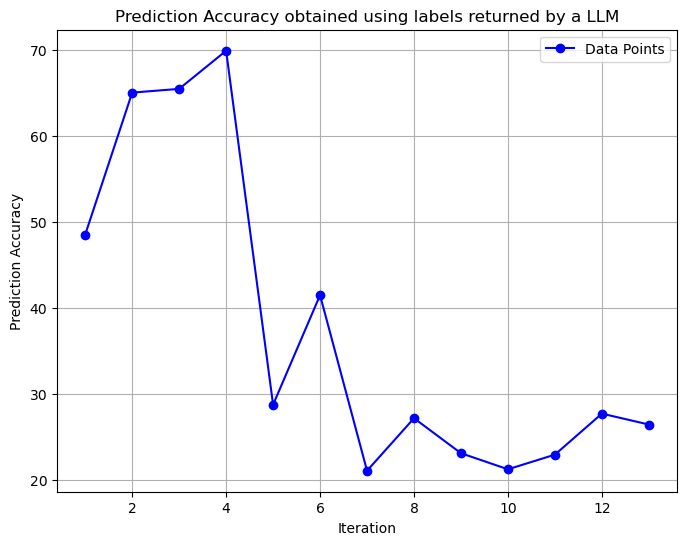

In [20]:
iterations_list1 = [i for i in range(1,14)]

plt.figure(figsize=(8, 6))
plt.plot(iterations_list1, accuracy_data, marker= 'o', linestyle = '-', color = 'b', label = 'Data Points')

plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title("Prediction Accuracy obtained using labels returned by a LLM")
plt.legend()
plt.grid(True)



print("Best Accuracy: " , best_accuracy)
plt.savefig('nemotron_accuracy.png', dpi = 300, bbox_inches = 'tight')
plt.show()
